# LA Times

develop a model to predict post performance for new posts a user may want to create for this account.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import json
import pandas as pd
import numpy as np
import zipfile
from pandas.io.json import json_normalize

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error

In [2]:
%%time

with zipfile.ZipFile('posts.json.zip') as myzip:
    with myzip.open('posts.json') as f:
        lines = f.readlines()
        data = [json.loads(line) for line in lines]

CPU times: user 4.44 s, sys: 302 ms, total: 4.74 s
Wall time: 4.75 s


In [3]:
%%time

df = json_normalize(data)

display(df.head())
display(df.shape)

,caption,created_time,description,feed_targeting.reach_estimate,id,insights.post_consumptions.description,insights.post_consumptions.id,insights.post_consumptions.name,insights.post_consumptions.period,insights.post_consumptions.title,...,insights.post_video_views_unique.name,insights.post_video_views_unique.period,insights.post_video_views_unique.title,insights.post_video_views_unique.values,link,link_to_post,message,name,picture,story
0,komonews.com,2015-09-17T20:50:00+0000,About 20 western Virginia high school students...,NaN,114431401958534_940695755998757,Lifetime: The number of clicks anywhere in you...,114431401958534_940695755998757/insights/post_...,post_consumptions,lifetime,Lifetime Post Consumptions,...,post_video_views_unique,lifetime,Lifetime Unique Video Views,[{'value': 0}],http://www.komonews.com/news/national/Students...,http://facebook.com/114431401958534_9406957559...,Do you think the Confederate flag should be ba...,Students suspended for clothing displaying Con...,https://external.xx.fbcdn.net/safe_image.php?d...,NaN
1,NaN,2015-09-17T20:20:01+0000,NaN,NaN,114431401958534_940684872666512,Lifetime: The number of clicks anywhere in you...,114431401958534_940684872666512/insights/post_...,post_consumptions,lifetime,Lifetime Post Consumptions,...,NaN,NaN,NaN,NaN,https://www.facebook.com/KOMONews/photos/a.121...,http://facebook.com/114431401958534_9406848726...,Seattle Seahawks' Russell Wilson answered lots...,Timeline Photos,https://fbcdn-photos-b-a.akamaihd.net/hphotos-...,NaN
2,komonews.com,2015-09-17T19:49:28+0000,Despite September looking like it will break o...,NaN,114431401958534_940684229333243,Lifetime: The number of clicks anywhere in you...,114431401958534_940684229333243/insights/post_...,post_consumptions,lifetime,Lifetime Post Consumptions,...,post_video_views_unique,lifetime,Lifetime Unique Video Views,[{'value': 0}],http://www.komonews.com/weather/blogs/scott/Ne...,http://facebook.com/114431401958534_9406842293...,"It'll be a bummer for snow lovers, but warm-we...","New forecasts still say mild winter, hot summe...",https://external.xx.fbcdn.net/safe_image.php?d...,NaN
3,komonews.com,2015-09-17T19:18:00+0000,Amazon is dangling a $50 tablet computer in it...,NaN,114431401958534_940637569337909,Lifetime: The number of clicks anywhere in you...,114431401958534_940637569337909/insights/post_...,post_consumptions,lifetime,Lifetime Post Consumptions,...,post_video_views_unique,lifetime,Lifetime Unique Video Views,[{'value': 0}],http://www.komonews.com/news/tech/Amazon-dangl...,http://facebook.com/114431401958534_9406375693...,What do you think of Amazon's cheaper tablet?,Amazon dangles $50 tablet computer to hook mor...,https://fbexternal-a.akamaihd.net/safe_image.p...,NaN
4,komonews.com,2015-09-17T18:45:00+0000,Earth's record-breaking heat is sounding an aw...,NaN,114431401958534_940535546014778,Lifetime: The number of clicks anywhere in you...,114431401958534_940535546014778/insights/post_...,post_consumptions,lifetime,Lifetime Post Consumptions,...,post_video_views_unique,lifetime,Lifetime Unique Video Views,[{'value': 0}],http://www.komonews.com/news/national/Earths-r...,http://facebook.com/114431401958534_9405355460...,Meteorologists say 2015 is a near certainty to...,Earth's record streak of record heat keeps on ...,https://external.xx.fbcdn.net/safe_image.php?d...,NaN


(8639, 359)

CPU times: user 27.6 s, sys: 240 ms, total: 27.9 s
Wall time: 27.9 s


In [4]:
insights = df[[col for col in df if col.startswith('insights')]]

In [5]:
pd.DataFrame((df.isna().sum()/df.shape[0]).sort_values(), columns=['Null %'])

,Null %
insights.post_story_adds.description,0.000000
insights.post_negative_feedback.id,0.000000
insights.post_negative_feedback.name,0.000000
insights.post_negative_feedback.period,0.000000
insights.post_negative_feedback.title,0.000000
insights.post_negative_feedback.values,0.000000
insights.post_negative_feedback_by_type.description,0.000000
insights.post_negative_feedback_by_type.id,0.000000
insights.post_negative_feedback_by_type.name,0.000000
insights.post_negative_feedback_by_type.period,0.000000


In [6]:
def check_value(x):
    if type(x) == list:
        return x[0]['value']
    else:
        return x

In [7]:
it = insights[[col for col in insights.columns if 'values' in col]]
it.head()

,insights.post_consumptions.values,insights.post_consumptions_by_type.values,insights.post_consumptions_by_type_unique.values,insights.post_consumptions_unique.values,insights.post_engaged_fan.values,insights.post_engaged_users.values,insights.post_fan_reach.values,insights.post_impressions.values,insights.post_impressions_by_paid_non_paid.values,insights.post_impressions_by_paid_non_paid_unique.values,...,insights.post_video_retention_graph_autoplayed.values,insights.post_video_retention_graph_clicked_to_play.values,insights.post_video_views.values,insights.post_video_views_autoplayed.values,insights.post_video_views_clicked_to_play.values,insights.post_video_views_organic.values,insights.post_video_views_organic_unique.values,insights.post_video_views_paid.values,insights.post_video_views_paid_unique.values,insights.post_video_views_unique.values
0,[{'value': 170}],"[{'value': {'other clicks': 151, 'link clicks'...","[{'value': {'other clicks': 91, 'link clicks':...",[{'value': 107}],[{'value': 117}],[{'value': 117}],[{'value': 3566}],[{'value': 4072}],"[{'value': {'paid': 0, 'total': 4072, 'unpaid'...","[{'value': {'paid': 0, 'total': 3583, 'unpaid'...",...,[{'value': {}}],[{'value': {}}],[{'value': 0}],[{'value': 0}],[{'value': 0}],[{'value': 0}],[{'value': 0}],[{'value': 0}],[{'value': 0}],[{'value': 0}]
1,[{'value': 88}],"[{'value': {'other clicks': 61, 'link clicks':...","[{'value': {'other clicks': 49, 'link clicks':...",[{'value': 65}],[{'value': 76}],[{'value': 77}],[{'value': 3560}],[{'value': 5297}],"[{'value': {'paid': 0, 'total': 5297, 'unpaid'...","[{'value': {'paid': 0, 'total': 3618, 'unpaid'...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,[{'value': 2169}],"[{'value': {'other clicks': 1162, 'link clicks...","[{'value': {'other clicks': 847, 'link clicks'...",[{'value': 1688}],[{'value': 1799}],[{'value': 2001}],[{'value': 37757}],[{'value': 65538}],"[{'value': {'paid': 0, 'total': 65538, 'unpaid...","[{'value': {'paid': 0, 'total': 43336, 'unpaid...",...,[{'value': {}}],[{'value': {}}],[{'value': 0}],[{'value': 0}],[{'value': 0}],[{'value': 0}],[{'value': 0}],[{'value': 0}],[{'value': 0}],[{'value': 0}]
3,[{'value': 238}],"[{'value': {'other clicks': 95, 'link clicks':...","[{'value': {'other clicks': 84, 'link clicks':...",[{'value': 197}],[{'value': 209}],[{'value': 212}],[{'value': 6036}],[{'value': 9226}],"[{'value': {'paid': 0, 'total': 9226, 'unpaid'...","[{'value': {'paid': 0, 'total': 6263, 'unpaid'...",...,[{'value': {}}],[{'value': {}}],[{'value': 0}],[{'value': 0}],[{'value': 0}],[{'value': 0}],[{'value': 0}],[{'value': 0}],[{'value': 0}],[{'value': 0}]
4,[{'value': 362}],"[{'value': {'other clicks': 241, 'link clicks'...","[{'value': {'other clicks': 161, 'link clicks'...",[{'value': 255}],[{'value': 306}],[{'value': 314}],[{'value': 19474}],[{'value': 32136}],"[{'value': {'paid': 0, 'total': 32136, 'unpaid...","[{'value': {'paid': 0, 'total': 20364, 'unpaid...",...,[{'value': {}}],[{'value': {}}],[{'value': 0}],[{'value': 0}],[{'value': 0}],[{'value': 0}],[{'value': 0}],[{'value': 0}],[{'value': 0}],[{'value': 0}]


# Create Consumption dataframe and join to features

In [8]:
new = it.applymap(lambda x: check_value(x)).select_dtypes(include=[np.number])

# Fill nulls with imputed data
new = new.fillna(method='pad')

## Look at captions
- create feature for komonews

In [9]:
features =pd.get_dummies(df['caption'].fillna('').str.contains(r'komonews.com'), 
                         drop_first=True, prefix='komonnews')

## Look at descriptions

In [10]:
df['description_parsed'] = df['description'].fillna('').str.lower()

## Create features for !, and ?

In [11]:
# features['$_True'] = pd.get_dummies(df['description'].fillna('').str.contains(r'\$'), 
#               prefix='$', drop_first=True)

features['!_True'] = pd.get_dummies(df['description'].fillna('').str.contains(r'\!'), 
              prefix='!', drop_first=True)

features['?_True'] = pd.get_dummies(df['description'].fillna('').str.contains(r'\?'), 
              prefix='?', drop_first=True)

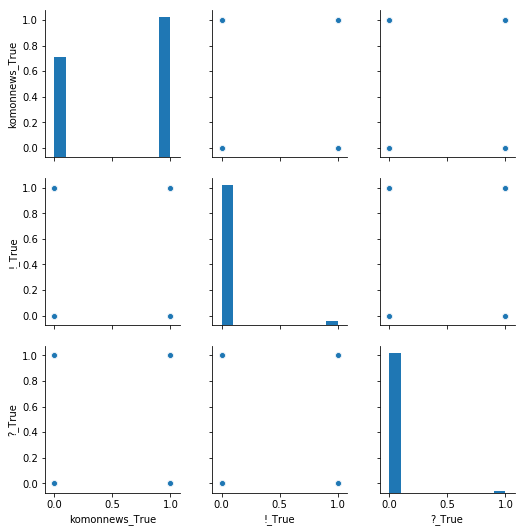

In [12]:
sns.pairplot(features)

## parse NLP features to be used later

In [13]:
# remove non alphabetic chars except .
df['description_parsed'] = df['description'].str.replace(r'[^a-z .]', '')

corpus = df['description_parsed'].str.cat().split('.')

# Remove stop words
vectorizer = CountVectorizer(stop_words='english', analyzer='word')
X = vectorizer.fit_transform(corpus)

pd.Series(vectorizer.vocabulary_).sort_values(ascending=False).head()

zoos          14506
zoomed        14505
zookeepers    14504
zookeeper     14503
zoo           14502
dtype: int64

## Parse Time and Create time features

In [14]:
df['created_time'] = pd.to_datetime(df['created_time'])

weekday_name = df['created_time'].dt.weekday_name
month = df['created_time'].dt.month_name()

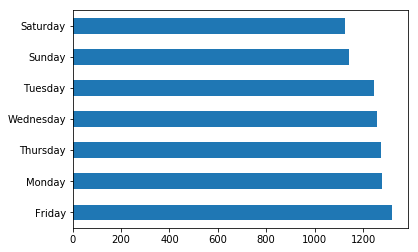

In [15]:
weekday_name.value_counts().plot.barh()
plt.show()

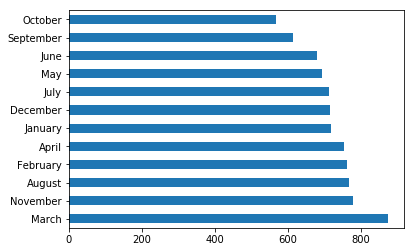

In [18]:
month.value_counts().plot.barh()
plt.show()

## March, Friday, and midnight have the most content

In [19]:
features = pd.concat([features, pd.get_dummies(weekday_name), 
                      pd.get_dummies(month)], 1)

features.head()

,komonnews_True,!_True,?_True,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,...,December,February,January,July,June,March,May,November,October,September
0,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
2,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
3,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
4,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1


## Join features with post values

In [20]:
data = pd.concat([features, new], 1, sort=False)

data.shape

(8639, 65)

## Develop Random Forest Regression model to predict insights.post_consumptions.values
- Random Forest will be a good choice, because we do not have much feature engineering


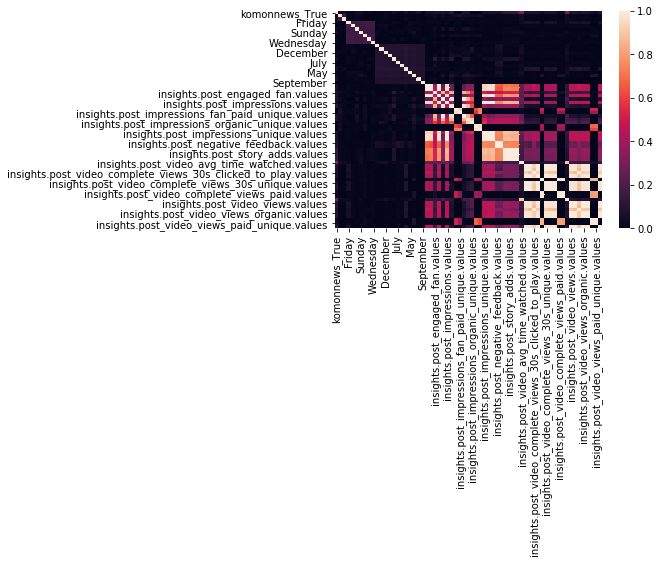

In [21]:
sns.heatmap(data.corr().abs())
plt.show()

## Dropping correlated variables actually makes the model worse

In [22]:
# # Create correlation matrix
# corr_matrix = data.corr().abs()

# # Select upper triangle of correlation matrix
# upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# # Find index of feature columns with correlation greater than 0.95
# to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# data = data.drop(to_drop, axis=1)

## Create training data

In [23]:
X = data.drop('insights.post_consumptions.values',1)
Y = data['insights.post_consumptions.values']

In [24]:
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.33, random_state=42)

## Fit random Forest Regressor

In [25]:
%%time

reg = RandomForestRegressor(n_estimators=100, random_state=0).fit(X_train, y_train)

CPU times: user 10.3 s, sys: 84.3 ms, total: 10.4 s
Wall time: 10.4 s


In [26]:
reg.score(X_test, y_test)

0.7621306580009509

## Show 10-fold cross-validation

In [27]:
%%time 

cross_val_score(reg, X, Y, cv=10)

CPU times: user 2min 14s, sys: 688 ms, total: 2min 15s
Wall time: 2min 15s


array([0.85027081, 0.95488736, 0.91579694, 0.96218359, 0.84264451,
       0.75960842, 0.96923762, 0.9821073 , 0.97884564, 0.98719734])

## Cross validation shows consistent R-squared values
    So overfitting is not a huge problem for this model

In [28]:
y_pred = reg.predict(X)

mean_absolute_error(Y, y_pred)

559.0792047690705

## The MAE for this solution is close to 560
- In addition cross validation for this solution is lower error than with highly correlated features dropped.
- It can only improve with more parsed features.

## TODO with more time
- parse actions into appropriate data columns
- Utilize NLP features
- Do feature engineering and filtering
- train using Logistic Regression, Random Forest, or Gradient Boosting Classifier to build a model for predicting wether a post should be posted at a particular time yes or no.
- test on new data, and evaluate performance